In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer

In [2]:
crash = pd.read_csv('Data/CGR_Crash_Data.csv')
crash.head(4)

,X,Y,OBJECTID,ROADSOFTID,BIKE,CITY,CRASHDATE,CRASHSEVER,CRASHTYPE,WORKZNEACT,...,VEH3DIR,VEH3TYPE,VEH3USE,WEATHER,WHEREONRD,YEAR,RDCITYTWP,RDNUMLANES,RDWIDTH,FRAMEWORK
0,-85.639647,42.927216,6001,929923,No,Grand Rapids,2007-02-16,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17
1,-85.639487,42.927213,6002,935745,No,Grand Rapids,2007-06-22,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Clear,On the Road,2007,Grand Rapids,2,42.0,17
2,-85.639387,42.927212,6003,926813,No,Grand Rapids,2007-01-08,Property Damage Only,Head-on,Work on Shoulder / Median,...,U,Uncoded & Errors,Uncoded & Errors,Snow,On the Road,2007,Grand Rapids,2,42.0,17
3,-85.639288,42.927210,6004,943813,No,Grand Rapids,2007-11-12,Property Damage Only,Side-Swipe Same,Uncoded & Errors,...,U,Uncoded & Errors,Uncoded & Errors,Cloudy,On the Road,2007,Grand Rapids,2,42.0,17


In [3]:
initial_shape = crash.shape
print(initial_shape)

(72977, 77)


## Columns Dropped
* Unfortunately, I do not know what the "**OBJECTID**" or "**ROADSOFTID**" columns mean, so I will drop them.
* Since all crashes occur in Grand Rapids, I will drop the "**CITY**" column.
* Since we have other features that may represent the time/date better than "**CRASHDATE**" we'll drop it.
* "**WORKZNEACT**", "**WORKZNECLO**", "**WORKZNETYP**", "**ANIMAL**" are primarily errors
* "**DAYOFMONTH**", "**DAYOFWEEK**" were fairly evenly distributed and did not seem to have any correlation with "**D1DRINKIN**"
* Wanted to use "**D2COND**", "**D3COND**", but not enough data recorded.
* "**FLEEINGSIT**" looks like it could be helpful, but not sure what it means, and far too few instances
* all read no for "**NONTRAFFIC**"
* Such low amounts of data on Vehichle defect, dropped "**V1DEFECT**", "**V2DEFECT**"
* Such low amounts of data on any third vehicle, drop '**D3DRINKIN**', '**DRIVER3AGE**', '**DRIVER3SEX**', '**V3DEFECT**', '**V3DAMAGE**', '**VEH3DIR**', '**VEH3TYPE**', '**VEH3USE**'


* Drop all V3's

In [4]:
labels = ["OBJECTID", "ROADSOFTID", "CITY", "CRASHDATE", "WORKZNEACT", "WORKZNECLO", "WORKZNETYP",
         "DAYOFMONTH", "DAYOFWEEK", "ANIMAL", "D2COND", "D3COND", "FARMEQUIP", "FLEEINGSIT", "NONTRAFFIC", 
         "NUMOFKILL", "ORV", "PUBLICPROP", "PEDESTRIAN", "SNOWMOBILE", "SCHOOLBUS", "TRAIN", "V1DEFECT", "V2DEFECT", 
           'DRIVER3AGE', 'DRIVER3SEX', 'V3DEFECT', 'V3DAMAGE', 'VEH3DIR', 'VEH3TYPE', 'VEH3USE',
           'DRIVER2AGE', 'DRIVER2SEX', 
          'V2DEFECT', 'V2DAMAGE', 'VEH2DIR', 'VEH2TYPE', 'VEH2USE',
          'FRAMEWORK', 'RDCITYTWP', 'YEAR'
         ]
crash = crash.drop(labels=labels, axis=1)

In [5]:
# these are the columns remaining
crash.columns

Index(['X', 'Y', 'BIKE', 'CRASHSEVER', 'CRASHTYPE', 'D1COND', 'D1DRINKIN',
       'D2DRINKIN', 'D3DRINKIN', 'DRIVER1AGE', 'DRIVER1SEX', 'EMRGVEH',
       'GRTINJSEVE', 'HITANDRUN', 'HOUR', 'MONTH', 'MOTORCYCLE', 'NOATYPEINJ',
       'NOBTYPEINJ', 'NOCTYPEINJ', 'NUMOFINJ', 'NUMOFOCCUP', 'NUMOFUNINJ',
       'NUMOFVEHIC', 'SPDLMTPOST', 'SPEEDLIMIT', 'SURFCOND', 'TRAFCTLDEV',
       'TRUCKBUS', 'V1DAMAGE', 'VEH1DIR', 'VEH1TYPE', 'VEH1USE', 'WEATHER',
       'WHEREONRD', 'RDNUMLANES', 'RDWIDTH'],
      dtype='object')

Using a series of rather ad-hoc statistical tests, I've determined that these features will be most relevant in training a model to predict whether or not Driver 1 was drinking or not. As with any trade-off, a more rigourous feature-selection process could have implications on the final model. If the model produces proves to be mediocre, I may revisit this decision.

In [9]:
#crash = pd.read_csv('Data/CGR_Crash_Data.csv')
crash = crash[['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE','DRIVER1SEX', 
               'EMRGVEH', 'HITANDRUN', 'SPEEDLIMIT', 'HOUR','MOTORCYCLE', 
               'NUMOFINJ', 'D1COND', 'D1DRINKIN']]
crash.columns

Index(['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE', 'DRIVER1SEX', 'EMRGVEH',
       'HITANDRUN', 'SPEEDLIMIT', 'HOUR', 'MOTORCYCLE', 'NUMOFINJ', 'D1COND',
       'D1DRINKIN'],
      dtype='object')

## Replacing Errors and Transforming data

* **D1COND**: 'Other', 'Uncoded & Errors', and 'Unknown' seem to mean the same thing, so we bin them together. Though 'Fatigue / Asleep', 'Sick', 'Medication', 'Emotional', and 'Physically Disabled' do not all mean the same thing, since there are so few instances we will bin them together.

In [92]:
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Other', 'Uncoded & Errors'], value = 'Unknown')
crash['D1COND'] = crash['D1COND'].replace(to_replace = ['Fatigue / Asleep', 'Sick', 'Medication', 'Emotional', 'Physically Disabled'], value = 'Fatigue / Sick')
crash['D1COND'].value_counts()

Appeared Normal    56412
Unknown            15890
Fatigue / Sick       675
Name: D1COND, dtype: int64

* **SPEEDLIMIT**: There are a ton of different values for the recorded speedlimits, so I will put them into bins and treat them as categorical variables

In [93]:
bins = [0, 25, 45, 65, 100]
labels = ['speed<25', '25<speed<45', '45<speed<65', '65<speed']
crash['SPEEDLIMIT_BINS'] = pd.cut(crash['SPEEDLIMIT'], bins=bins, labels=labels)
# Now drop the original 'SPEEDLIMIT' column to eliminate redundancy
crash = crash.drop(['SPEEDLIMIT'], axis = 1)

In [94]:
crash['SPEEDLIMIT_BINS'].value_counts()

speed<25       30127
25<speed<45    26480
65<speed        9025
45<speed<65     7329
Name: SPEEDLIMIT_BINS, dtype: int64

In [24]:
crash = crash.dropna()

* **Hour**: This column has been a bit tricky, but I believe I've come to a solution. It contains at what hour the crash occured at (ranging from 0-23). It did not make sense to me to treat this column as a numerical variable, since the model would interpret 2pm as twice 1pm... while that does not make logical sense. However, I felt that to treat each hour as it's own category wouldn't accurately capture the information that the hour conveys (for example, it would not capture the fact that 12pm and 12am are 12 hours apart, while 12pm and 1pm are sequential). For that reason, I mapped each hour to two separate values (think of them like X and Y coordinates) using a trigonometric transformation. As displayed below, when plotted, the hours values create a perfect cirlce (think of it like a clock), which seems to be a more meaningful representation of the hour that the crash took place.
Sure, I could have left it as numeric or categorical, and the model may have worked fine... but it also may not have.

In [96]:
crash['HOUR_X']=np.sin(2. * np.pi * crash.HOUR / 24.)
crash['HOUR_Y']=np.cos(2. * np.pi * crash.HOUR / 24.)

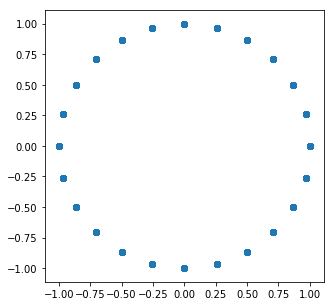

In [97]:
# Hence, the time of day is now cyclic (just as in reality)
plt.figure(figsize = (5,5))
plt.scatter(crash.HOUR_X, crash.HOUR_Y)

In [98]:
# Now that we have our two 'HOUR_X' and 'HOUR_Y' coords, we drop the original "HOUR" feature
crash = crash.drop(['HOUR'], axis=1)

## Encoding Categorical Variables

In [100]:
# Here are our current columns
crash.columns

Index(['X', 'Y', 'CRASHSEVER', 'DRIVER1AGE', 'DRIVER1SEX', 'EMRGVEH',
       'HITANDRUN', 'MOTORCYCLE', 'NUMOFINJ', 'D1COND', 'D1DRINKIN',
       'SPEEDLIMIT_BINS', 'HOUR_X', 'HOUR_Y'],
      dtype='object')

In [101]:
dummies = pd.get_dummies(crash[['CRASHSEVER', 'DRIVER1SEX',
                            'EMRGVEH', 'HITANDRUN',
                            'MOTORCYCLE', 'D1COND',
                             'D1DRINKIN']])

In [102]:
dummies.head()

,CRASHSEVER_Fatal,CRASHSEVER_Injury,CRASHSEVER_Property Damage Only,DRIVER1SEX_F,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_No,EMRGVEH_Yes,HITANDRUN_No,HITANDRUN_Yes,MOTORCYCLE_No,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1COND_Unknown,D1DRINKIN_No,D1DRINKIN_Yes
0,0,0,1,1,0,0,1,0,0,1,1,0,1,0,0,1,0
1,0,0,1,0,1,0,1,0,0,1,1,0,0,0,1,1,0
2,0,0,1,1,0,0,1,0,1,0,1,0,1,0,0,1,0
3,0,0,1,0,1,0,1,0,0,1,1,0,1,0,0,1,0
4,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0


In [103]:
# Drop the column with target variable (D1DRINKIN) and the columns for which we created dummy variables
crash_ = crash.drop(['CRASHSEVER', 'DRIVER1SEX',
                            'EMRGVEH', 'HITANDRUN',
                            'MOTORCYCLE', 'D1COND',
                             'D1DRINKIN'], axis=1)
# Define the feature set X.
crash = pd.concat([crash_, dummies], axis=1)
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72977 entries, 0 to 72976
Data columns (total 24 columns):
X                                  72977 non-null float64
Y                                  72977 non-null float64
DRIVER1AGE                         72977 non-null int64
NUMOFINJ                           72977 non-null int64
SPEEDLIMIT_BINS                    72961 non-null category
HOUR_X                             72977 non-null float64
HOUR_Y                             72977 non-null float64
CRASHSEVER_Fatal                   72977 non-null uint8
CRASHSEVER_Injury                  72977 non-null uint8
CRASHSEVER_Property Damage Only    72977 non-null uint8
DRIVER1SEX_F                       72977 non-null uint8
DRIVER1SEX_M                       72977 non-null uint8
DRIVER1SEX_U                       72977 non-null uint8
EMRGVEH_No                         72977 non-null uint8
EMRGVEH_Yes                        72977 non-null uint8
HITANDRUN_No                       72977

In [104]:
# Drop columns to eliminate redundancy
crash = crash.drop(['DRIVER1SEX_F', 'EMRGVEH_No', 'D1COND_Unknown', 'MOTORCYCLE_No', 'CRASHSEVER_Property Damage Only', 'HITANDRUN_No',  'D1DRINKIN_No' ], axis=1)
crash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72977 entries, 0 to 72976
Data columns (total 17 columns):
X                         72977 non-null float64
Y                         72977 non-null float64
DRIVER1AGE                72977 non-null int64
NUMOFINJ                  72977 non-null int64
SPEEDLIMIT_BINS           72961 non-null category
HOUR_X                    72977 non-null float64
HOUR_Y                    72977 non-null float64
CRASHSEVER_Fatal          72977 non-null uint8
CRASHSEVER_Injury         72977 non-null uint8
DRIVER1SEX_M              72977 non-null uint8
DRIVER1SEX_U              72977 non-null uint8
EMRGVEH_Yes               72977 non-null uint8
HITANDRUN_Yes             72977 non-null uint8
MOTORCYCLE_Yes            72977 non-null uint8
D1COND_Appeared Normal    72977 non-null uint8
D1COND_Fatigue / Sick     72977 non-null uint8
D1DRINKIN_Yes             72977 non-null uint8
dtypes: category(1), float64(4), int64(2), uint8(10)
memory usage: 4.1 MB


In [35]:
crash.head()

,X,Y,DRIVER1AGE,NUMOFINJ,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1DRINKIN_Yes
0,-85.639647,42.927216,62,0,-0.258819,-9.659258e-01,0,0,0,0,0,1,0,1,0,0
1,-85.639487,42.927213,31,0,-1.000000,-1.836970e-16,0,0,1,0,0,1,0,0,0,0
2,-85.639387,42.927212,22,0,0.866025,-5.000000e-01,0,0,0,0,0,0,0,1,0,0
3,-85.639288,42.927210,30,0,-0.866025,-5.000000e-01,0,0,1,0,0,1,0,1,0,0
4,-85.639288,42.927210,44,0,-0.707107,-7.071068e-01,0,0,1,0,0,0,0,1,0,0


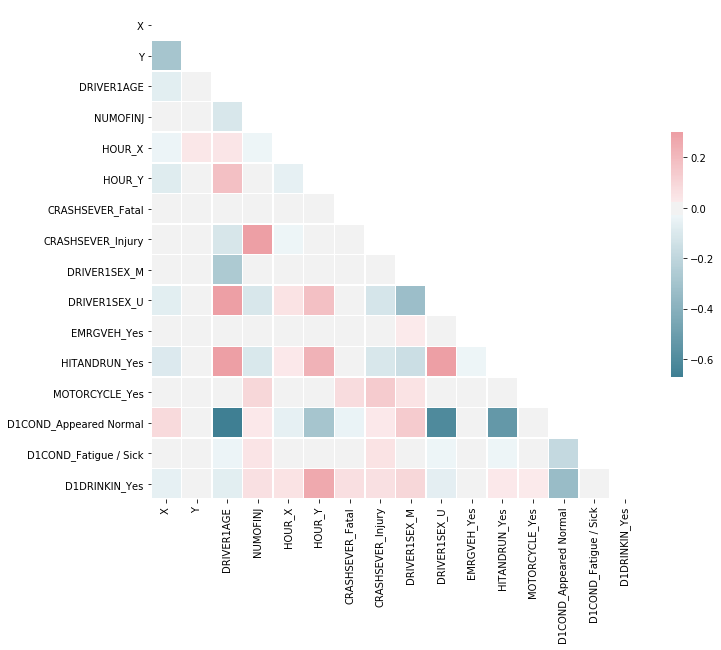

In [105]:
# Compute the correlation matrix
corr = crash.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Fit regressor to impute missing ages
* **DRIVER1AGE**: There are over 10,000 Driver ages listed as 999. I believe that this is an error and potentially represents ages that went unrecorded. Usually with missing ages, I'd either drop them or impute the average age or something along those lines, but since there are so many missing, and since the age of driver 1 seems to be such a crucial feature, I will fit a regressor to impute the missing ages with a prediction (think of it like an educated guess).

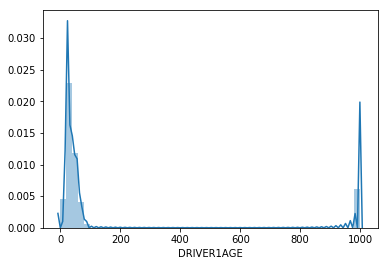

In [106]:
# As you can see, there are a ton of 999 year old drivers... leaving this would skew our model
sns.distplot(crash['DRIVER1AGE'])

* Big shout out to [this kaggle notebook](https://www.kaggle.com/athi94/investigating-imputation-methods) for helping me impute the missing ages with a regressor

In [110]:
crash.columns

Index(['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ', 'SPEEDLIMIT_BINS', 'HOUR_X',
       'HOUR_Y', 'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M',
       'DRIVER1SEX_U', 'EMRGVEH_Yes', 'HITANDRUN_Yes', 'MOTORCYCLE_Yes',
       'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick', 'D1DRINKIN_Yes'],
      dtype='object')

In [108]:
crash['DRIVER1AGE'] = crash['DRIVER1AGE'].replace(to_replace = 999, value = np.NaN)
crash['DRIVER1AGE'].isnull().sum()

8979

In [109]:
crash_cl = crash
crash_reg = crash.dropna()

In [111]:
# These are the features I use to fit my regressor to impute missing ages. Notice that I do not use 
# the ultimate target variable, 'D1DRINKIN_Yes', as this may skew the predictions
X_cols = ['X', 'Y','NUMOFINJ', 'HOUR_X', 'HOUR_Y',
       'CRASHSEVER_Fatal', 'CRASHSEVER_Injury', 'DRIVER1SEX_M', 'DRIVER1SEX_U',
       'EMRGVEH_Yes', 'HITANDRUN_Yes', 'MOTORCYCLE_Yes',
       'D1COND_Appeared Normal', 'D1COND_Fatigue / Sick']
y_cols = 'DRIVER1AGE'

temp_X = crash_reg.loc[:, X_cols]
temp_Y = crash_reg.loc[:, y_cols]

In [112]:
from sklearn.linear_model import LinearRegression
age_lm = LinearRegression()
age_lm.fit(temp_X, temp_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [113]:
nan_inds = crash.DRIVER1AGE.isnull().nonzero()[0]

for i in nan_inds:
    crash.set_value(i, 'DRIVER1AGE', age_lm.predict(crash_cl.loc[i, X_cols].values.reshape(1, -1)))

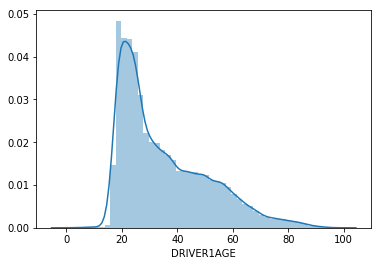

In [115]:
# This age distribution looks much better!
sns.distplot(crash['DRIVER1AGE'])

## Scaling Numerical Variables

In [117]:
sc_X = StandardScaler()
X_scaled = sc_X.fit_transform(crash[['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ']])

In [118]:
X_scaled_df = pd.DataFrame(X_scaled, columns = ['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ'])

In [119]:
crash_ = crash.drop(['X', 'Y', 'DRIVER1AGE', 'NUMOFINJ'], axis=1)

In [120]:
crash = pd.concat([X_scaled_df, crash_], axis=1)

---

## Exporting Processed Data to CSV

In [121]:
crash.head()

,X,Y,DRIVER1AGE,NUMOFINJ,SPEEDLIMIT_BINS,HOUR_X,HOUR_Y,CRASHSEVER_Fatal,CRASHSEVER_Injury,DRIVER1SEX_M,DRIVER1SEX_U,EMRGVEH_Yes,HITANDRUN_Yes,MOTORCYCLE_Yes,D1COND_Appeared Normal,D1COND_Fatigue / Sick,D1DRINKIN_Yes
0,0.406318,-0.996140,1.682777,-0.416816,25<speed<45,-0.258819,-9.659258e-01,0,0,0,0,0,1,0,1,0,0
1,0.411006,-0.996237,-0.261671,-0.416816,25<speed<45,-1.000000,-1.836970e-16,0,0,1,0,0,1,0,0,0,0
2,0.413936,-0.996298,-0.826188,-0.416816,25<speed<45,0.866025,-5.000000e-01,0,0,0,0,0,0,0,1,0,0
3,0.416866,-0.996358,-0.324395,-0.416816,25<speed<45,-0.866025,-5.000000e-01,0,0,1,0,0,1,0,1,0,0
4,0.416866,-0.996358,0.553743,-0.416816,25<speed<45,-0.707107,-7.071068e-01,0,0,1,0,0,0,0,1,0,0


In [123]:
crash.to_csv('Data/Crash_data_prepared.csv', index=False)